# Technical Analysis
CodeIT Suisse 2019

## Problem Statement

Use the first few *known* values of a *stock price* as **training data** to recommend buy and sell trades for the next few *unknown* values of **test data**.

Unfortunately, training data values are *truncated* to integers.

On a bright side, you know function family that forms the price on the *full index range* (**training data** immediately followed by **test data**):

\begin{equation}
price_t = base + trend * t + \sum_{i=1}^{sine\_count} scale_i * \sin(2\pi * period\_count_i * t)
\end{equation}

where

\begin{align}
t \in [0, 1]\>evenly\>spaced\>on\>the\>full\>index\>range
\end{align}

### Small Example

In [1]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
from app import generation, trade_optimizer
import pprint

importlib.reload(generation)

def show_sample():
    builder = generation.ScenarioBuilder(1, train_size=30, test_size=60)
    builder.set_base().set_trend((20, 20)).add_waves(1, period_count_range=(3, 3), scale_range=(4, 4))
    scenario = builder.build()
    optimal_trades = list(trade_optimizer.get_optimal_trades(scenario.test_signal))

    fig = plt.figure()
    fig.set_size_inches(16, 4)
    plt.title(f"Illustrative example of sine_count=1 with {scenario.train_size} values of training data and {scenario.test_size} values of test data")
    plt.plot(np.arange(scenario.train_size), scenario.train_signal, color='blue')
    plt.plot(scenario.train_size + np.arange(scenario.test_size), scenario.test_signal, color='orange')
    min_y = min(scenario.train_signal.min(), scenario.test_signal.min())
    money = 1
    for i, trade in enumerate(optimal_trades):
        price = scenario.test_signal[trade]
        x = scenario.train_size + trade
        isSell = i % 2
        plt.axvline(x, 0, price, color=['green', 'red'][isSell])
        if isSell:
            money = price * security
            text = f"sell index {x}, price {price:.1f} => {money:,.2f} cash"
        else:
            security = money / price
            text = f"buy index {x}, price {price:.1f}"
            
        plt.text(x+0.3,min_y,text,rotation=90)
        
    print("Train data - your input (blue line in the image below):")
    pprint.pprint(scenario.train_signal.tolist(), compact=True, width=120)
    print()
    print("Test data - floating point values (orange line in the image below):")
    pprint.pprint(scenario.test_signal.tolist(), compact=True, width=120)
    print()
    print("Optimal trades - the output you need to produce (alternating green and red lines in the image below):")
    pprint.pprint([scenario.train_size + t for t in optimal_trades], compact=True)    
    print()
    print(f"Max final cash amount is {money:.2f}")
    print()
    m = scenario.model_parameters
    print("This example uses the following function family parameters:")
    print(f"Base={m[0]}, trend={m[1]}, scale_1={m[2]:.1f}, period_count_1={m[3]}, sine_count={scenario.sine_count}")

show_sample()

Train data - your input (blue line in the image below):
[241, 242, 243, 244, 244, 245, 246, 246, 246, 246, 246, 246, 245, 245, 244, 244, 243, 243, 242, 242, 241, 241, 241, 242,
 242, 243, 244, 244, 245, 246]

Test data - floating point values (orange line in the image below):
[248.0237288698771, 249.08090060113744, 250.08826187106925, 251.01083737788557, 251.8174407897403, 252.4820684229782,
 252.98506131430463, 253.31398375532103, 253.46417902881325, 253.43897751163246, 253.24954784430986, 252.91439781844994,
 252.4585472866212, 251.91241005636977, 251.3104347351166, 250.6895652648834, 250.08758994363023, 249.5414527133788,
 249.0856021815501, 248.75045215569014, 248.56102248836754, 248.53582097118675, 248.68601624467897, 249.01493868569537,
 249.5179315770218, 250.1825592102597, 250.98916262211443, 251.91173812893075, 252.91909939886256, 253.97627113012288,
 255.0460520535713, 256.0906774110047, 257.0735066150713, 257.96066067139145, 258.72253618853586, 259.3351283166435,
 259.781103

### Scoring
Input data contains 4 scenarios in this order:

| Scenario | sine_count | weight |
|-|-|-|
| 1 | 1 | 0.1 |
| 2 | 2 | 0.2 |
| 3 | 3 | 0.3 |
| 4 | 4 | 0.4 |

Assuming the initial amount of cash is 1, scenario score is:
\begin{equation}
score_i = \dfrac{final\_amount_i - 1}{max\_final\_amount_i - 1}
\end{equation}

where

* **final_amount** - final amount of cash after trading on your recommendations
* **max_final_amount** - final amount of cash after trading on optimal strategy a.k.a. "buy low, sell high"

Total score is a weighted sum of the scenario scores:
\begin{align}
total\_coorinator\_score = 100 * \sum_{i=1}^{scenario\_count} weight_i * score_i
\end{align}

### Input
List of 4 **training data** sequences, each containing 100 values indexed [0, 99]

Boundaries:
\begin{align*}
\\&base \in [200, 300)
\\&trend \in [-100, 100)
\\&scale_i \in [5, 15)
\\&period\_count_i \in [10, 100)
\\&price_t > 0
\end{align*}

### Output
List of trade recommendations for each **test data** sequence. Every **test data** sequence is indexed [100, 1099] hence every trade recommendation is assumed to contain a sequence of alternating buy-sell indexes, monotonically increasing and contained within [100, 1099]

Every trade utilizes all available resources, i.e.:
- buy converts all cash to stock
- sell converts all stock back to cash

If the last recommended trade is a buy, then a sell will be implied at the index 1099.

#### Sample Input

In [2]:
import pprint
import matplotlib.pyplot as plt
import numpy as np
from app import generation, trade_optimizer, evaluate

scenarios = generation.get_standard_scenarios(1)
pprint.pprint(evaluate.create_challenge_input(scenarios), width=106, compact=True)

[[283, 285, 287, 288, 290, 291, 291, 291, 290, 289, 287, 285, 283, 280, 278, 276, 275, 273, 273, 273, 273,
  274, 276, 277, 279, 282, 284, 286, 287, 289, 289, 290, 289, 288, 287, 285, 283, 281, 279, 276, 275, 273,
  272, 271, 271, 272, 273, 275, 277, 279, 281, 283, 285, 286, 288, 288, 288, 288, 287, 285, 283, 281, 279,
  277, 275, 273, 271, 270, 270, 270, 271, 272, 274, 276, 278, 280, 282, 284, 285, 286, 287, 287, 286, 285,
  284, 282, 279, 277, 275, 273, 271, 270, 269, 269, 269, 270, 271, 273, 275, 277],
 [268, 273, 277, 280, 281, 280, 277, 273, 268, 264, 261, 259, 259, 261, 263, 266, 269, 271, 271, 270, 268,
  265, 262, 260, 259, 259, 261, 265, 269, 274, 278, 280, 280, 278, 275, 270, 264, 259, 255, 253, 253, 255,
  258, 262, 267, 271, 273, 274, 274, 272, 269, 266, 263, 262, 262, 264, 266, 269, 272, 274, 274, 273, 270,
  266, 261, 257, 253, 252, 252, 255, 259, 264, 270, 274, 278, 279, 278, 276, 272, 267, 263, 259, 257, 257,
  258, 261, 263, 266, 268, 269, 268, 266, 263, 260, 258, 257,

#### Sample Output

In [3]:
optimal_trades = [list(s.train_size + t for t in trade_optimizer.get_optimal_trades(s.test_signal)) for s in scenarios]
pprint.pprint(optimal_trades, width=120, compact=True)

[[100, 105, 118, 130, 143, 155, 167, 180, 192, 204, 217, 229, 242, 254, 266, 279, 291, 303, 316, 328, 341, 353, 366,
  378, 390, 403, 415, 427, 440, 452, 465, 477, 489, 502, 514, 526, 539, 551, 564, 576, 589, 601, 613, 625, 638, 650,
  663, 675, 688, 700, 712, 725, 737, 749, 762, 774, 787, 799, 811, 824, 836, 848, 861, 873, 886, 898, 911, 923, 935,
  948, 960, 972, 985, 997, 1010, 1022, 1034, 1047, 1059, 1071, 1084, 1096],
 [100, 103, 111, 118, 125, 131, 138, 146, 154, 160, 167, 174, 182, 189, 196, 202, 210, 218, 225, 231, 238, 245, 253,
  261, 267, 273, 281, 289, 296, 303, 309, 316, 324, 332, 338, 345, 352, 360, 367, 374, 380, 388, 396, 403, 409, 416,
  423, 431, 439, 445, 451, 459, 467, 474, 481, 487, 494, 502, 510, 516, 523, 530, 538, 545, 552, 558, 566, 574, 581,
  587, 594, 601, 609, 617, 623, 629, 637, 645, 652, 659, 665, 672, 680, 688, 694, 700, 708, 716, 723, 730, 736, 744,
  752, 759, 765, 772, 779, 787, 795, 801, 807, 815, 823, 830, 837, 843, 850, 858, 866, 872, 879, 886, 894

### Some Inspirational Visualization
**<font color='blue'>Blue</font>** - training data<br/>
**<font color='orange'>Orange</font>** - test data

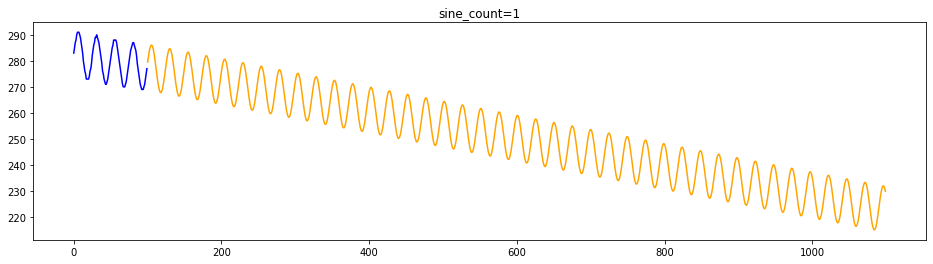

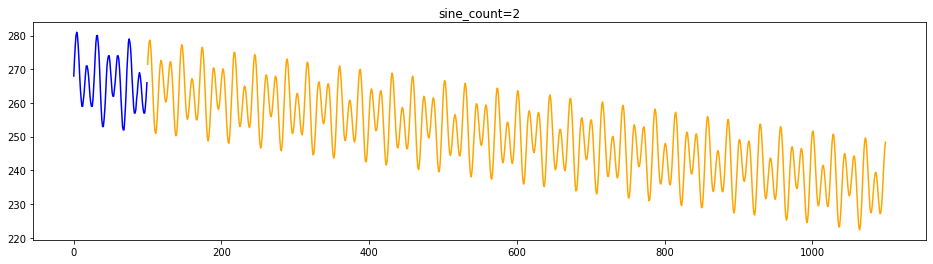

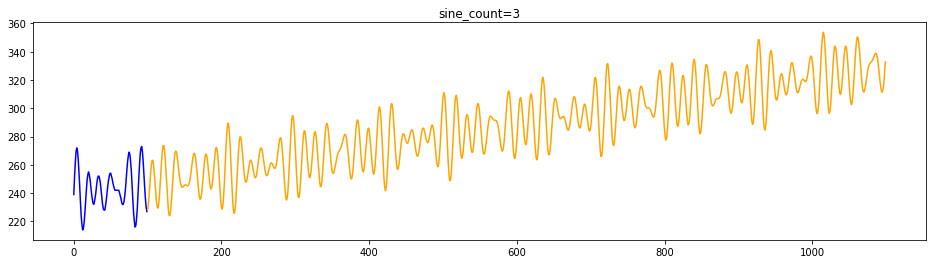

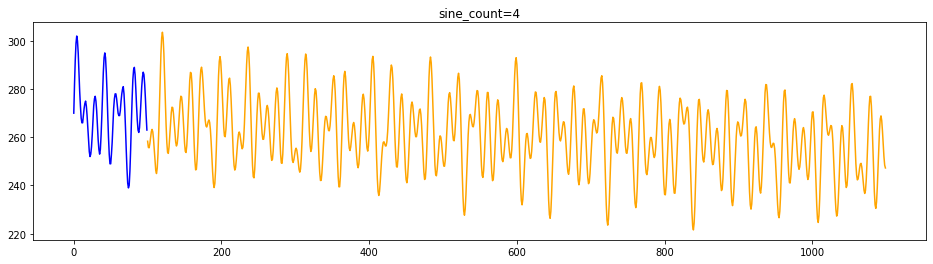

In [4]:
for scenario, optimals in zip(scenarios, optimal_trades):
    fig = plt.figure()
    fig.set_size_inches(16, 4)
    plt.title(f"sine_count={scenario.sine_count}")
    plt.plot(np.arange(scenario.train_size), scenario.train_signal, color='blue')
    plt.plot(scenario.train_size + np.arange(scenario.test_size), scenario.test_signal, color='orange')